## Importing basic libraries

In [2]:
from google.cloud import storage
from StringIO import StringIO

import os
import numpy as np
import pandas as pd

#Preprocessing, model selection & metrics import
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale = 2)

import warnings
warnings.filterwarnings('ignore')

## Read dataset

In [3]:
client = storage.Client()
# 
bucket = client.get_bucket('nameofbucket')
# Then do other things...
blob_train_values = bucket.get_blob('folder/train.csv')
blob_test_values = bucket.get_blob('folder/test.csv')

bt_train_values = blob_train_values.download_as_string()
bt_test_values = blob_test_values.download_as_string()

s_train_values = str(bt_train_values)
s_test_values = str(bt_test_values)

s_train_values = StringIO(s_train_values)
s_test_values = StringIO(s_test_values)

train = pd.read_csv(s_train_values)
test = pd.read_csv(s_test_values)

In [4]:
print('Train data shape', train.shape)
print('Test data shape', test.shape)

('Train data shape', (8523, 12))
('Test data shape', (5681, 11))


In [5]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


In [8]:
train.select_dtypes('object').columns

Index([u'Item_Identifier', u'Item_Fat_Content', u'Item_Type',
       u'Outlet_Identifier', u'Outlet_Size', u'Outlet_Location_Type',
       u'Outlet_Type'],
      dtype='object')

## Explaratory data analysis

### Checking categorical column and there unique values

In [9]:
#Let us combine both train & test for checking categorical values
df_full = pd.concat([train, test], axis=0).reset_index(drop=True)
print 'Full dataset shape', df_full.shape

Full dataset shape (14204, 12)


In [10]:
#Updaring `Item_Fat_Content` column with correct category value
df_full.loc[df_full['Item_Fat_Content'].isin(['LF','low fat']), 'Item_Fat_Content'] = 'Low Fat'
df_full.loc[df_full['Item_Fat_Content'].isin(['reg']), 'Item_Fat_Content'] = 'Regular'

In [11]:
#collect `Item_Identifier` of missing `Item_Weight` in full dataset
#loop over the `Item_Identifier` and impute `mean` of other `Item_Weights` of the same 'Item_Identifier's

miss_items_weight = df_full.loc[df_full['Item_Weight'].isnull(), 'Item_Identifier'].values

for item in miss_items_weight:
    df_full.loc[((df_full['Item_Weight'].isnull()) & (df_full['Item_Identifier'] == item)), 
                'Item_Weight'] = df_full.loc[df_full['Item_Identifier'] == item, 'Item_Weight'].mean()

In [12]:
#collect `Outlet_Type` of missing `Outlet_Size` in full dataset
#loop over the `Outlet_Type` and impute `mode` of other `Outlet_Size` of the same 'Outlet_Type's

miss_outlet_type = df_full.loc[df_full['Outlet_Size'].isnull(), 'Outlet_Type'].values

for item in miss_outlet_type:
    df_full.loc[((df_full['Outlet_Size'].isnull()) & (df_full['Outlet_Type'] == item)), 
                'Outlet_Size'] = df_full.loc[df_full['Outlet_Type'] == item, 'Outlet_Size'].mode()[0]

Now we have imputed missing values in both `Item_Weight` & `Outlet_size` columns using mode.

## Feature engineering

Creating `Item_MRP` mean among `Outlet_Identifier` group and mapping with dataframe

In [13]:
temp2 = df_full.groupby('Outlet_Identifier')['Item_MRP'].agg(['mean']).rename({'mean':'Outlet_Item_MRP_mean'}, axis=1)
df_full = pd.merge(df_full, temp2, on='Outlet_Identifier', how='left')

Grouping `Item_Identifier,Outlet_Identifier`,`Outlet_Type`,`Item_Type` to create *mean,min,max,std* of `Item_MRP`,`Item_visibility` columns

In [14]:
df_full['mrp_mean'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_MRP'].transform('mean')
df_full['mrp_min'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_MRP'].transform('min')
df_full['mrp_max'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_MRP'].transform('max')
#df_full['mrp_std'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_MRP'].transform('std')

In [15]:
df_full['mrp_itemtype_mean'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_MRP'].transform('mean')
df_full['mrp_itemtype_min'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_MRP'].transform('min')
df_full['mrp_itemtype_max'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_MRP'].transform('max')
df_full['mrp_itemtype_std'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_MRP'].transform('std')

In [16]:
df_full['mrp_outlet_item_mean'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_MRP'].transform('mean')
df_full['mrp_outlet_item_min'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_MRP'].transform('min')
df_full['mrp_outlet_item_max'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_MRP'].transform('max')
df_full['mrp_outlet_item_std'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_MRP'].transform('std')

In [17]:
temp3 = df_full.groupby('Item_Identifier')['Item_Visibility'].agg(['mean']).rename({'mean':'item_visib_mean'}, axis=1)
df_full = pd.merge(df_full, temp3, on='Item_Identifier', how='left')

In [18]:
df_full['item_visib_mean'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Visibility'].transform('mean')
df_full['item_visib_min'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Visibility'].transform('min')
df_full['item_visib_max'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Visibility'].transform('max')
#df_full['item_visib_std'] = df_full.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Visibility'].transform('std')

In [19]:
df_full['itemtype_visib_mean'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_Visibility'].transform('mean')
df_full['itemtype_visib_min'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_Visibility'].transform('min')
df_full['itemtype_visib_max'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_Visibility'].transform('max')
df_full['itemtype_visib_std'] = df_full.groupby(['Item_Identifier','Item_Type'])['Item_Visibility'].transform('std')

In [20]:
df_full['outlet_itemvisib_mean'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_Visibility'].transform('mean')
df_full['outlet_itemvisib_min'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_Visibility'].transform('min')
df_full['outlet_itemvisib_max'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_Visibility'].transform('max')
df_full['outlet_itemvisib_std'] = df_full.groupby(['Outlet_Type','Item_Type'])['Item_Visibility'].transform('std')

### Frequency encoding

In [21]:
#Frequency encoding the `Item_Identifier` column
item_identi_dict = df_full['Item_Identifier'].value_counts().to_dict()
df_full['Item_Identifier_freq'] = df_full['Item_Identifier'].map(item_identi_dict)

In [22]:
#Frequency encoding the 'Outlet_Identifier' column
outlet_indenti_dict = df_full['Outlet_Identifier'].value_counts().to_dict()
df_full['Outlet_Identifier_freq'] = df_full['Outlet_Identifier'].map(outlet_indenti_dict)

In [23]:
#Seperate train & test from the cleaned full dataset df_full
train = df_full[:train.shape[0]]
test = df_full[train.shape[0]:]

### One hot encode categorical columns

In [24]:
encoded = pd.get_dummies(train, columns=['Item_Fat_Content','Item_Type',
                                         'Outlet_Establishment_Year','Outlet_Size',
                                         'Outlet_Location_Type','Outlet_Type'])
encoded.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Outlet_Item_MRP_mean,mrp_mean,mrp_min,mrp_max,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,FDA15,249.8092,3735.1380,0.016047,9.30,OUT049,141.163199,249.8092,249.8092,249.8092,...,0,1,0,1,0,0,0,1,0,0
1,DRC01,48.2692,443.4228,0.019278,5.92,OUT018,141.000899,48.2692,48.2692,48.2692,...,0,1,0,0,0,1,0,0,1,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,OUT049,141.163199,141.6180,141.6180,141.6180,...,0,1,0,1,0,0,0,1,0,0
3,FDX07,182.0950,732.3800,0.000000,19.20,OUT010,141.159742,182.0950,182.0950,182.0950,...,0,0,1,0,0,1,1,0,0,0
4,NCD19,53.8614,994.7052,0.000000,8.93,OUT013,141.128428,53.8614,53.8614,53.8614,...,1,0,0,0,0,1,0,1,0,0


## Correlation with target 

In [25]:
corr = encoded.corr()['Item_Outlet_Sales']
corr[np.argsort(corr, axis=0)[::-1]]

Item_Outlet_Sales                  1.000000
mrp_itemtype_max                   0.567772
mrp_itemtype_min                   0.567758
mrp_itemtype_mean                  0.567683
Item_MRP                           0.567574
mrp_mean                           0.567574
mrp_min                            0.567574
mrp_max                            0.567574
Outlet_Identifier_freq             0.415482
Outlet_Type_Supermarket Type3      0.311192
Outlet_Size_Medium                 0.204701
Outlet_Type_Supermarket Type1      0.108765
Outlet_Establishment_Year_1985     0.080669
Outlet_Item_MRP_mean               0.074791
mrp_outlet_item_mean               0.059457
Outlet_Location_Type_Tier 2        0.058261
Outlet_Establishment_Year_2004     0.052823
Outlet_Location_Type_Tier 3        0.046376
Outlet_Establishment_Year_1999     0.034264
outlet_itemvisib_min               0.033342
Outlet_Establishment_Year_2007     0.032610
mrp_outlet_item_std                0.030464
mrp_outlet_item_max             

`Item_MRP`,`Outlet_Type_Supermarket Type3`,`Outlet_Size_Medium` columns have positive correlation with sales.
`Outlet_Type_Grocery Store`,`Outlet_Size_Small` columns have weak negative correlation.
Let us proceed further to check whether this details help in future process.

## Data visualisation

Text(0.5, 1.0, 'Sale distribution')

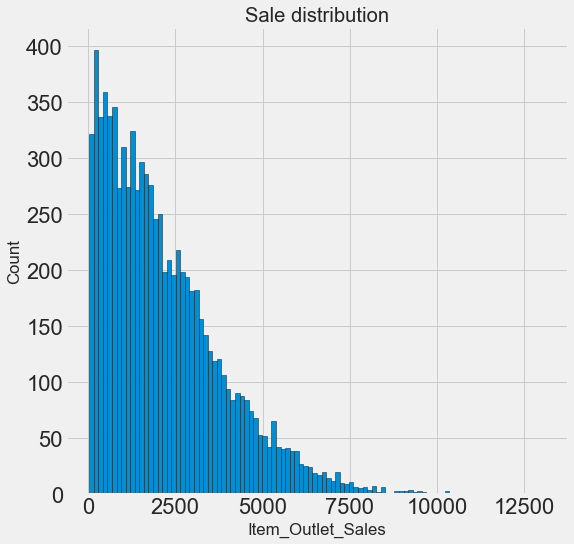

In [21]:
#univariate to check target column distribution

figsize(8,8)

plt.style.use('fivethirtyeight')
plt.hist(train['Item_Outlet_Sales'], bins=100, edgecolor='k')
plt.xlabel('Item_Outlet_Sales'); plt.ylabel('Count')
plt.title('Sale distribution')

Our first plot shows that we are having right skewed target values, caused due to outlier.

In [33]:
train.loc[train['Item_Outlet_Sales'] > 12000]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
5223,FDQ19,7.35,Regular,0.014296,Fruits and Vegetables,242.6512,OUT027,1985,Medium,Tier 3,Supermarket Type3,12117.5600
7188,NCE42,21.10,Low Fat,0.010551,Household,234.9958,OUT027,1985,Medium,Tier 3,Supermarket Type3,13086.9648


### Two variable plots

C:\Users\SPSWFH\miniconda3\envs\notebook1\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Item MRP vs Item outlet sales')

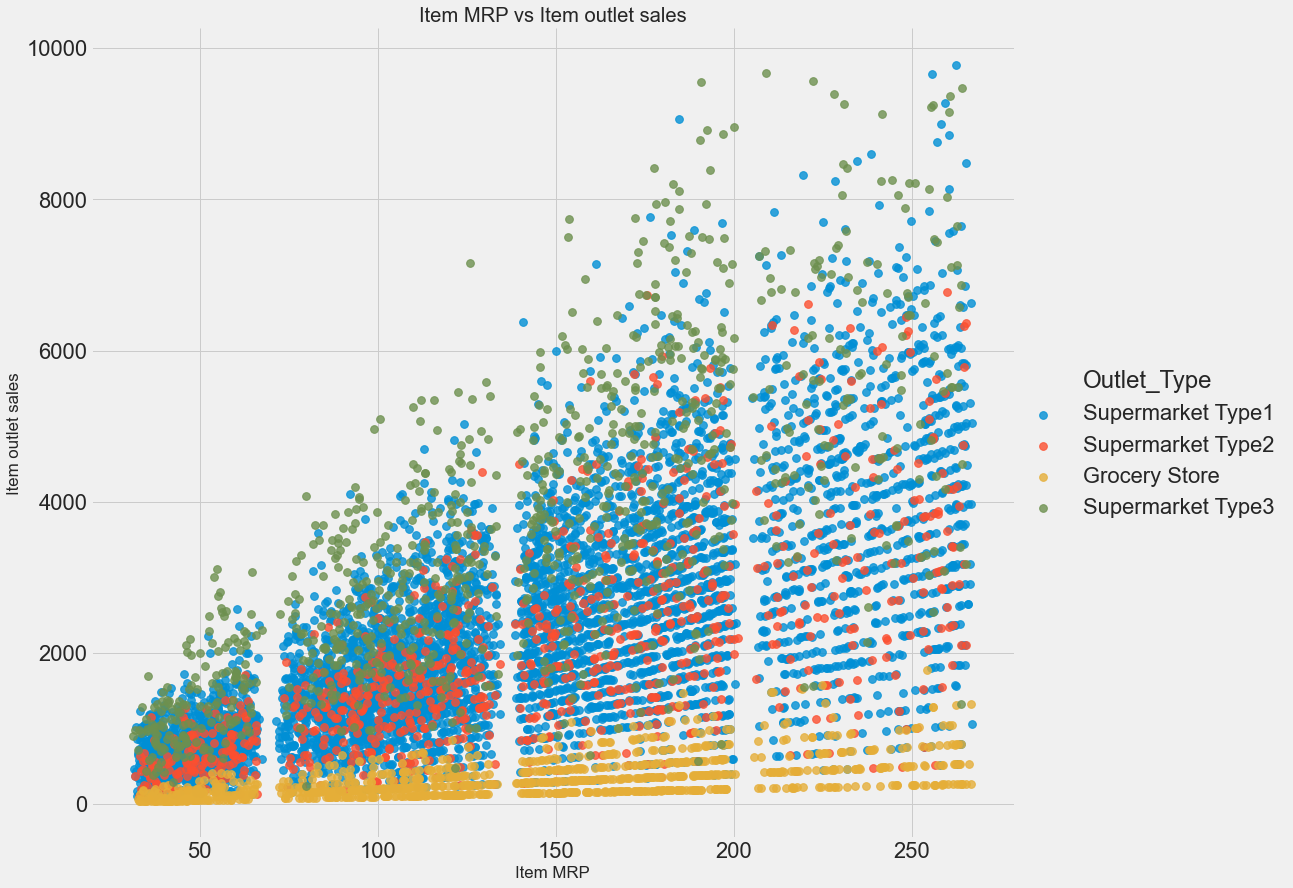

In [42]:
figsize(8,8)
sns.lmplot(x='Item_MRP', y='Item_Outlet_Sales', hue='Outlet_Type',
          data=train, scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          height = 12, aspect = 1.2)
plt.xlabel('Item MRP'); plt.ylabel('Item outlet sales')
plt.title('Item MRP vs Item outlet sales')

`Item MRP` having positive correleation with our target `Item_Outlet_Sales`.
1. We also used `Outlet_Type` as third variable in this plot which give us a nice picture which explains, `Grocery Store` are having less correlation or negative as we seen already in corr map earlier, when compared to other types of outlets.
2. The other 3 Supermarket types shows positive correlation with the target variable.

### Density plots

Text(0.5, 1.0, 'Item outlet sales density with Outlet Identifier')

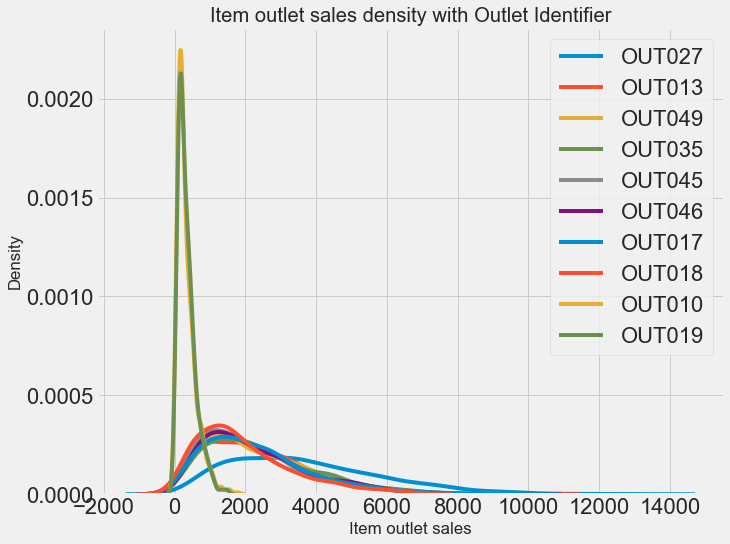

In [57]:
outlet_identifier = train['Outlet_Identifier'].value_counts().index

figsize(10,8)
for num,val in enumerate(outlet_identifier):
    subset = train[train['Outlet_Identifier'] == val]
    sns.kdeplot(subset['Item_Outlet_Sales'], label=val)
plt.xlabel('Item outlet sales'); plt.ylabel('Density')
plt.legend()
plt.title('Item outlet sales density with Outlet Identifier')

Few `Outlet_Identifier`s having different patterns, which may be have some influence in correlation.

Text(0.5, 1.0, 'Item outlet sales density with Outlet location')

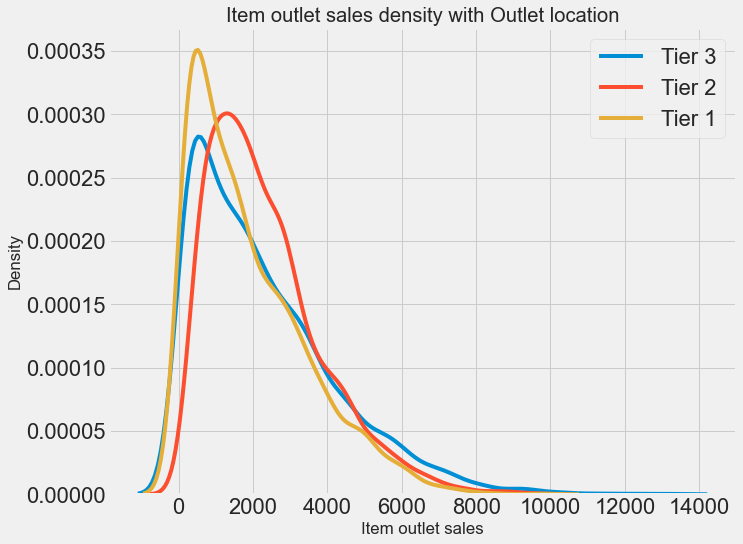

In [59]:
outlet_location = train['Outlet_Location_Type'].value_counts().index

figsize(10,8)
for val in outlet_location:
    subset = train[train['Outlet_Location_Type'] == val]
    sns.kdeplot(subset['Item_Outlet_Sales'], label=val)
plt.xlabel('Item outlet sales'); plt.ylabel('Density')
plt.legend()
plt.title('Item outlet sales density with Outlet location')

`Outlet_Location` having less differnce between them against the target sales.

Text(0.5, 1.0, 'Item outlet sales density with Outlet type')

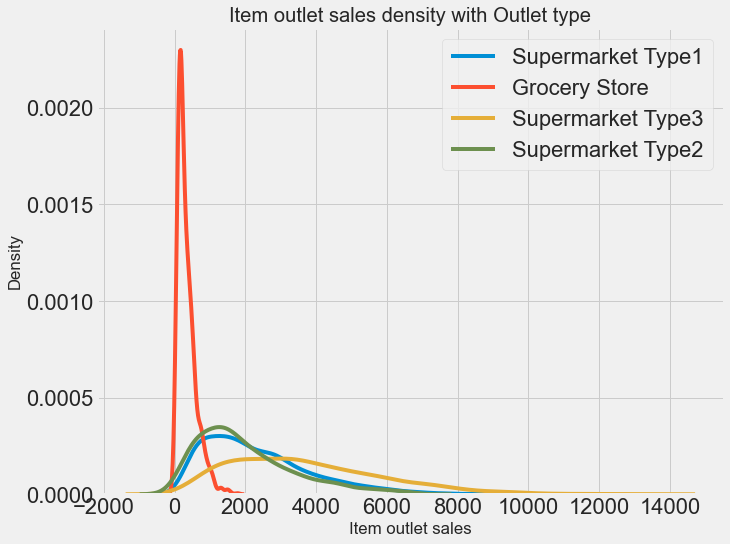

In [61]:
outlet_type = train['Outlet_Type'].value_counts().index

figsize(10,8)
for val in outlet_type:
    subset = train[train['Outlet_Type'] == val]
    sns.kdeplot(subset['Item_Outlet_Sales'], label=val)
plt.xlabel('Item outlet sales'); plt.ylabel('Density')
plt.legend()
plt.title('Item outlet sales density with Outlet type')

From this plot `Outlet_Type` also having certain change in density between the categories against target variable.
Hence the density plot helped us on identifying how much the categorical features will help for our model to learn different patterns from our data. Let us ensure this in upcoming model creation section.

### Checking collinear features

In [28]:
corr_matrix = train.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1).corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.90)]
print('Number of columns having collinearity with other columns other than target: ', len(to_drop))

('Number of columns having collinearity with other columns other than target: ', 13)


In [29]:
to_drop

['mrp_mean',
 'mrp_min',
 'mrp_max',
 'mrp_itemtype_mean',
 'mrp_itemtype_min',
 'mrp_itemtype_max',
 'item_visib_mean',
 'item_visib_min',
 'item_visib_max',
 'itemtype_visib_max',
 'outlet_itemvisib_max',
 'outlet_itemvisib_std',
 'Outlet_Identifier_freq']

In [30]:
train = train.drop(columns=to_drop, axis=1)
test = test.drop(columns=to_drop, axis=1)

Let us convert the target values as lograthimic to avoid skew effect on our model

In [31]:
train['Item_Outlet_Sales'] = np.log1p(train['Item_Outlet_Sales'])

Let us check distribution plot after applying lograthimic to target data

<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

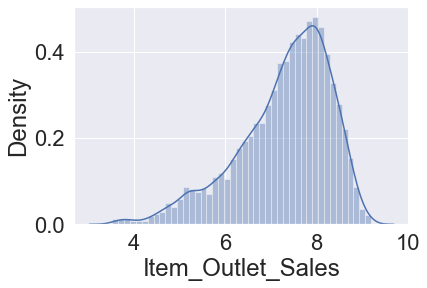

In [13]:
sns.distplot(train['Item_Outlet_Sales'])

#### Encode train & test columns

In [32]:
one_hot_cols = ['Item_Fat_Content','Item_Type','Outlet_Size','Outlet_Location_Type',
                'Outlet_Type','Outlet_Establishment_Year']
train_new = pd.get_dummies(train, columns=one_hot_cols)
test_new = pd.get_dummies(test, columns=one_hot_cols)

In [33]:
X = train_new.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)
y = train_new['Item_Outlet_Sales']
test = test_new.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'], axis=1)

In [34]:
#Create scaler object
scaler = StandardScaler()

#fit on train
scaler.fit(X)

#transform both train & test
X_final = scaler.transform(X)
test = scaler.transform(test)

#### Split train & test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)
print 'X_train shape', X_train.shape
print 'y_train shape', y_train.shape
print 'X_test shape', X_test.shape
print 'y_test shape', y_test.shape

X_train shape (5966, 52)
y_train shape (5966,)
X_test shape (2557, 52)
y_test shape (2557,)


In [36]:
#convert y to one dimensional array
y_train = np.array(y_train).reshape((-1,))
y_test = np.array(y_test).reshape((-1,))

### Modelling

#### Import libraries

In [37]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_squared_error

In [38]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_and_evaluate(model):
    model.fit(X_train, y_train)
    
    #predict
    model_pred = model.predict(X_test)
    model_rmse = rmse(y_test, model_pred)
    return model_rmse

In [39]:
#Linear Regression with default params
lr = LinearRegression()
lr_rmse = fit_and_evaluate(lr)
print 'Linear regression RMSE = %0.4f' %lr_rmse

Linear regression RMSE = 0.5370


In [46]:
#Support vector
svm = SVR(C = 1000, gamma = 0.1)
svm_rmse = fit_and_evaluate(svm)
print 'Support vector machine regressor RMSE = %0.4f' %svm_rmse

Support vector machine regressor RMSE = 0.8061


In [40]:
#Random forest regressor
rfr = RandomForestRegressor(random_state=60)
rfr_rmse = fit_and_evaluate(rfr)
print 'Random forest regressor RMSE = %0.4f' %rfr_rmse

Random forest regressor RMSE = 0.5691


In [41]:
#gradient boosting regressor
gbr = GradientBoostingRegressor(random_state=60)
gbr_rmse = fit_and_evaluate(gbr)
print 'Gradient boosting regressor RMSE = %0.4f' %gbr_rmse

Gradient boosting regressor RMSE = 0.5218


In [42]:
#KNeighbors regressor
knn = KNeighborsRegressor(n_neighbors=10)
knn_rmse = fit_and_evaluate(knn)
print 'KNeighbors regressor RMSE = %0.4f' %knn_rmse

KNeighbors regressor RMSE = 0.6756


In [43]:
#LightGBM
lgb = lgb.LGBMRegressor()
lgb_rmse = fit_and_evaluate(lgb)
print 'Light GBM regressor = %0.4f' %lgb_rmse

Light GBM regressor = 0.5275


In [44]:
#XGboost regressor
xgbr = xgb.XGBRegressor()
xgbr_rmse = fit_and_evaluate(xgbr)
print 'XGboost regressor = %0.4f' %xgbr_rmse

XGboost regressor = 0.5206


In [45]:
#kernel ridge
kr = KernelRidge(kernel='polynomial', degree=2)
kr_rmse = fit_and_evaluate(kr)
print 'Kernel ridge regressor = %0.4f' %kr_rmse

Kernel ridge regressor = 0.5324


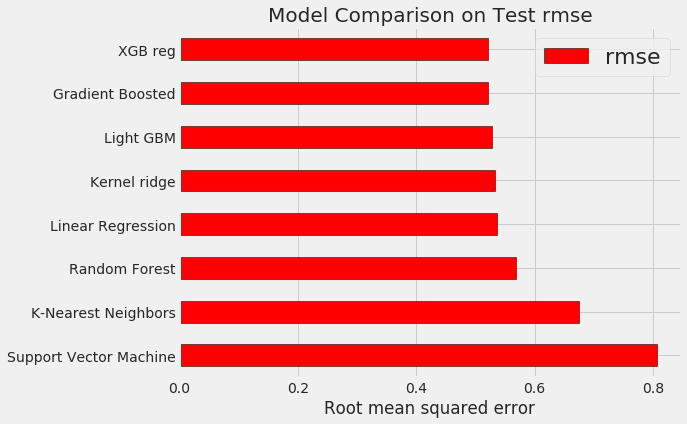

In [47]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors', 'Light GBM', 
                                           'XGB reg', 'Kernel ridge'],
                                 'rmse': [lr_rmse, svm_rmse, rfr_rmse, 
                                         gbr_rmse, knn_rmse,lgb_rmse,xgbr_rmse,kr_rmse]})

# Horizontal bar chart of test mae
model_comparison.sort_values('rmse', ascending = False).plot(x = 'model', y = 'rmse', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Root mean squared error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test rmse', size = 20);

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score

In [49]:
#used code from kaggle credits to https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard#Modelling
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [50]:
averaged_models = AveragingModels(models = (xgbr, gbr, kr, lgb))

avg_rmse = fit_and_evaluate(averaged_models)
print 'averaged (xgbr,gbr,kr,lgb) rmse = %0.4f' %avg_rmse

averaged (xgbr,gbr,kr,lgb) rmse = 0.5199


In [51]:
averaged_models.fit(X_train, y_train)
y_pred_avg = averaged_models.predict(test)
y_pred_avg

array([7.29190184, 7.1338566 , 6.30824415, ..., 7.45410504, 8.13934817,
       7.0493175 ])

In [52]:
blob_test_values = bucket.get_blob('folder/test.csv')

bt_test_values = blob_test_values.download_as_string()

s_test_values = str(bt_test_values)

s_test_values = StringIO(s_test_values)

test_sub = pd.read_csv(s_test_values)

In [53]:
test_for_submit = test_sub[['Item_Identifier','Outlet_Identifier']]

In [54]:
y_pred_final = pd.DataFrame(np.expm1(y_pred_avg), columns=['Item_Outlet_Sales'])
sub_df = pd.concat([test_for_submit, y_pred_final], axis=1)

In [41]:
sub_df.to_csv('submit4.csv', index=False)